# Some attempt at Particle Tracking

In [518]:
# Importing things

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq

from lab_functions import *

In [519]:
# where is the data?
loc = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/2024-03-11/'
filename = 'Results.csv'

# read in as dataframe
df = pd.read_csv(loc + filename)

# select x and y positions of bead for all 83 frames
# get rid of anomalous last point
x = np.array(df['x'])[:-1]
y = np.array(df['y'])[:-1]

In [520]:
# Conversion Factor
pixels_microns = 15.36
pm_err = 0.5

x_mic = x*(1/pixels_microns)
y_mic = y*(1/pixels_microns)

x_mic_err = np.abs(x*(1/(pixels_microns+pm_err)) - x*(1/pixels_microns))
y_mic_err = np.abs(y*(1/(pixels_microns+pm_err)) - y*(1/pixels_microns))

Text(0.5, 1.0, 'Particle Tracks over 3 Seconds \n NB Errors on this plot only include uncertainties from \n varying frame rate')

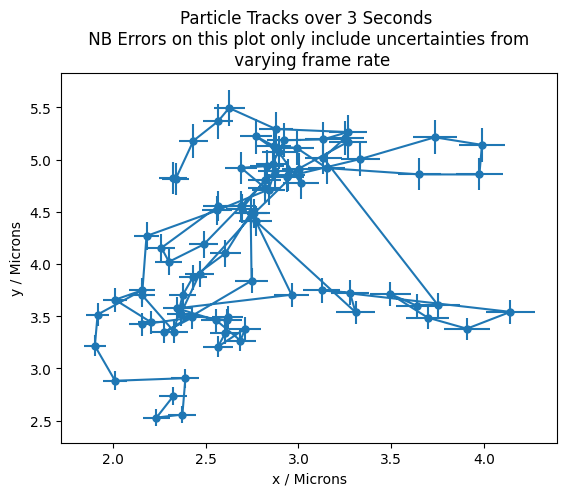

In [521]:
# Plot x and y trajectory

plt.errorbar(x_mic,y_mic, yerr = y_mic_err, xerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-')
plt.xlabel('x / Microns')
plt.ylabel('y / Microns')
plt.title('Particle Tracks over 3 Seconds \n NB Errors on this plot only include uncertainties from \n varying frame rate')

Text(0, 0.5, 'Position / Microns')

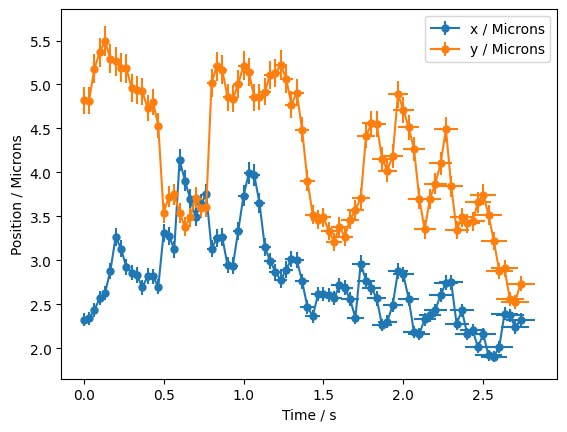

In [522]:
# Frames per second on camera
fps = 30
fps_err = 1

# Set time axis in seconds
time = np.arange(x.size) / 30
time_err = np.arange(x.size) * np.abs(1/31 - 1/30) # fps error is 1

# plot x and y over time
plt.errorbar(time,x_mic, xerr = time_err, yerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic, xerr = time_err, yerr = y_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position / Microns')

Text(0.5, 1.0, 'Particle Position with Time')

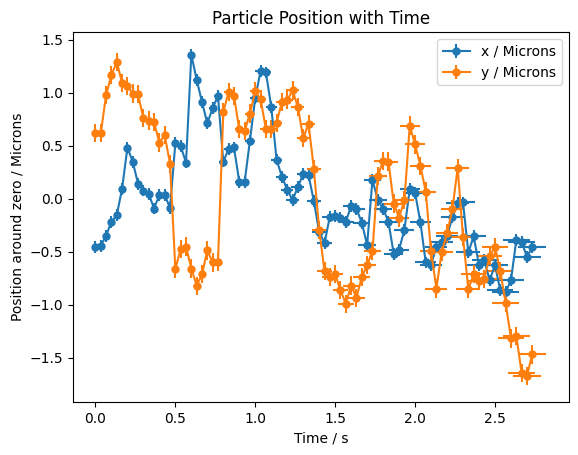

In [523]:
# Find mean of particle tracks to centre data on zero
x_mean = np.mean(x_mic)
y_mean = np.mean(y_mic)

# Error on mean = standard error
x_stderr = np.std(x_mic) / np.sqrt(len(x_mic))
y_stderr = np.std(y_mic) / np.sqrt(len(y_mic))

# Subtract mean from data
x_mic0 = x_mic - x_mean
y_mic0 = y_mic - y_mean

# Errors
x_mic0_err = np.abs( (x_mic - (x_mean+x_stderr)) - (x_mic - x_mean) )
y_mic0_err = np.abs( (y_mic - (y_mean+y_stderr)) - (y_mic - y_mean) )

# plot x and y over time
plt.errorbar(time,x_mic0, xerr = time_err, yerr = x_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic0, xerr = time_err, yerr = y_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position around zero / Microns')
plt.title('Particle Position with Time')

In [524]:
def fourier_calc(data, sample_number):

    # Compute transform and normalise by length / 2
    fast_four = fft(data, n = sample_number) / (len(data) / 2)

    # Compute amplitude squared and divide by measurement time
    ps = np.abs(fast_four)**2 / time[-1]

    # Calculate frequency components (is the sample spacing right?)
    freq = fftfreq(sample_number, d=1.0/fps)

    return ps, freq

Consider Error on Particle Tracking Centre as dominant from now on

In [525]:
# Look at error in particle

# Radius of Beads
radius = 2.56e-6 / 2 # in metres
radius_err = 0.01e-6 / 2

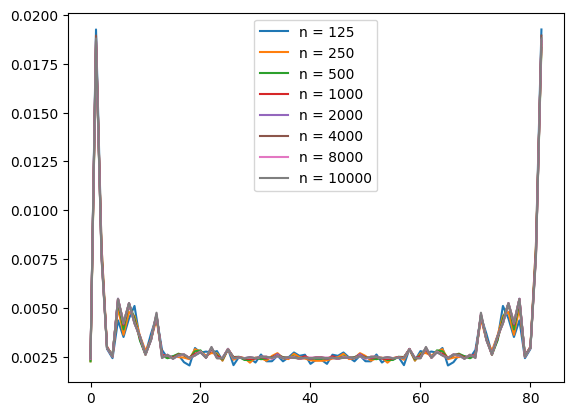

In [526]:
# Use random error simulation

# Generate power spectrum
ps, freq = fourier_calc(x_mic0, x_mic0.size)

# Empty list for errors
many_errs = []
many_errsf = []
mean_errs = []
mean_errsf = []

# How many interations?
n = np.array([125,250,500,1000,2000,4000,8000,10000])

for j in range(n.size):

    # Loop to do random distribution many times
    for i in range(n[j]):

        # random distribution of number between plus/minus 1/2 particle radius
        rand_dist = (np.random.rand(x_mic0.size)*2*radius*1e6 - radius*1e6)*(1/2)

        # Generate power spectrum with random error
        ps_rand, freq_rand = fourier_calc(x_mic0 + rand_dist, x_mic0.size)

        # Find difference in power spectrum
        ps_err_rand = np.abs(ps - ps_rand)
        freq_err_rand = np.abs(freq - freq_rand)

        # Add to big list
        many_errs.append(ps_err_rand)
        many_errsf.append(freq_err_rand)

    # Take the mean of the iterations
    ps_err_lots = np.mean(np.array(many_errs), axis = 0)
    freq_err_lots = np.mean(np.array(many_errsf), axis = 0)

    # Add to a big list
    mean_errs.append(ps_err_lots)
    mean_errsf.append(freq_err_lots)

    # Plot to see convergence behaviour
    plt.plot(np.arange(np.size(mean_errs[j])), mean_errs[j], label = 'n = {}'.format(n[j]), ms = 5)

# plt.errorbar(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o', ms = 3)
# plt.errorbar(freq_rand,ps_rand,label = 'With random error', linestyle = '', marker = 'o', ms = 3)
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e-7,0)
plt.legend()


In [527]:
''' Take error on power spectrum to be the erros generated from 10,000 random iterations'''
ps_err = mean_errs[-1]
freq_err = mean_errsf[-1]

Text(0, 0.5, 'Fourier Transform Squared / Arb Units')

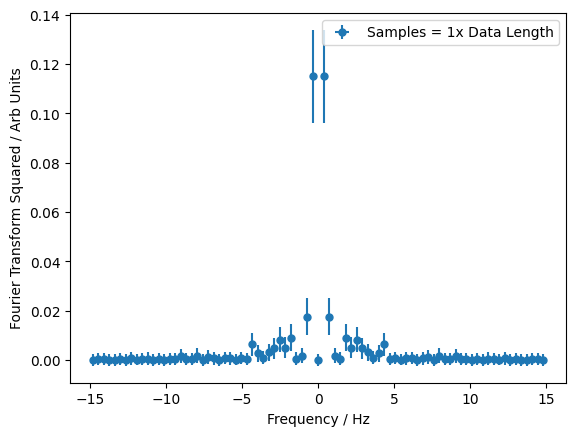

In [528]:
# Plot using above function
plt.errorbar(freq, ps, xerr = freq_err, yerr = ps_err, ms = 5, fmt = 'o', linestyle = '',label = 'Samples = {}x Data Length'.format(1))
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Fourier Transform Squared / Arb Units')

In [529]:
# try getting rid of first data point
# point = 1
# freq = np.delete(freq,point)
# freq_err = np.delete(freq_err,point)
# ps = np.delete(ps,point)
# ps_err = np.delete(ps_err,point)

print(freq_err.size, ps_err.size)

# Make errorbars the right shape to only see upper bars
ps_err_upper = np.zeros([2,ps_err.size])
ps_err_upper[1,:] = ps_err

83 83


C:\Users\abiga\AppData\Local\Temp\ipykernel_21780\1619000596.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8,0)


(1e-08, 4.674151990031322)

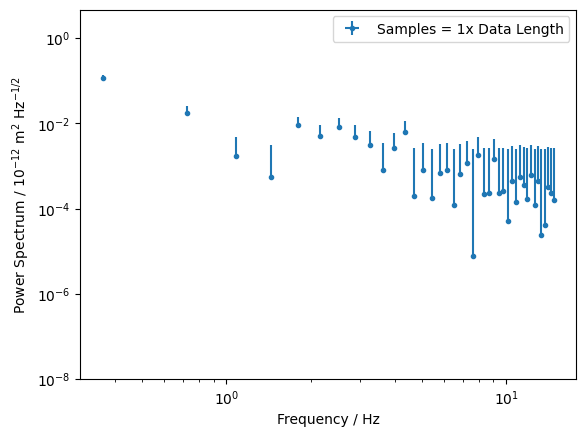

In [530]:
# Use a log scale
plt.errorbar(freq, ps, xerr = freq_err, yerr = ps_err_upper, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o', ms = 3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
plt.ylim(1e-8,0)

In [542]:
# Fit the above to Lorenzian Power Spectrum

def Lorentzian(x,A,f_0):
    return A / ((1 + x/f_0)**2)

ig = np.array([0.12,0.1])

# Fits to different errors in fit
yfit, parameters, perrors, chisq_reduced, p_value, dof = fit_labs(freq,ps,np.mean(ps_err),Lorentzian,ig)
#yfitb, parametersb, perrorsb, chisq_reducedb, p_valueb, dofb = fit_labs(freq,ps,ps_err,Lorentzian,ig)

In [546]:
# try fitting with asymmetric error bars
import lmfit

def residualsL(params, x, y_data):
    A = params['A'].value
    f_0 = params['f_0'].value
    y_calc = Lorentzian(x, A, f_0)
    return y_data - y_calc

parameterss = lmfit.Parameters()
parameterss.add("A", value=0.12, vary=True, min=0.1, max=1000)
parameterss.add("k", value=0.1, vary=True, min=0, max=1000)

result = lmfit.minimize(residualsL, parameterss, args=(freq, ps))
lmfit.report_fit(result.params)

KeyError: 'f_0'

C:\Users\abiga\AppData\Local\Temp\ipykernel_21780\3966230362.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(1e-8,0)


The Amplitude of the Lorentzian is 0.01943330440984499 pm 0.003254428429470827 10^-12 m$^2$ Hz^-1/2$
The Cutoff Frequency is 0.2564618016216416 pm 0.006337187777680407 Hz
The reduced chi squared value for the fit is 15.16447451084485


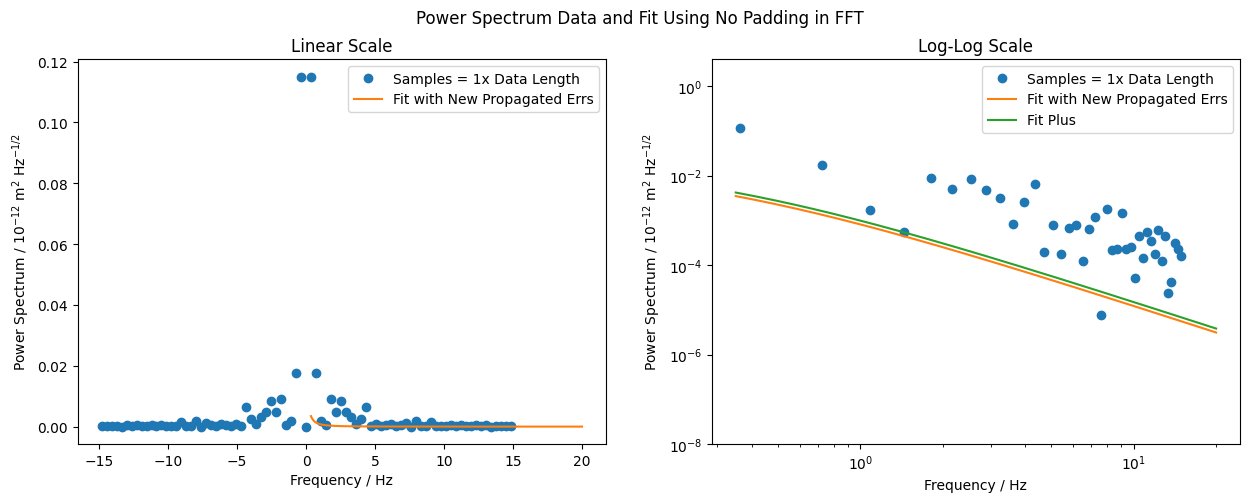

In [543]:
# Plot with Fit
# Use a log scale

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))

some_fs = np.linspace(0.35,20,1000)

fig.suptitle('Power Spectrum Data and Fit Using No Padding in FFT')

# Axis 1 - normal scale
ax1.plot(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax1.plot(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit with New Propagated Errs', linestyle = '-')
ax1.legend()
ax1.set_xlabel('Frequency / Hz')
ax1.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax1.set_title('Linear Scale')

# Axis 2 - log scale
ax2.loglog(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax2.loglog(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit with New Propagated Errs', linestyle = '-')
ax2.loglog(some_fs, Lorentzian(some_fs,parameters[0]+perrors[0],parameters[1]+perrors[1]), label = 'Fit Plus', linestyle = '-')
ax2.legend()
ax2.set_xlabel('Frequency / Hz')
ax2.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax2.set_ylim(1e-8,0)
ax2.set_title('Log-Log Scale')

print('The Amplitude of the Lorentzian is {} pm {} 10^-12 m$^2$ Hz^-1/2$'.format(parameters[0], perrors[0]))
print('The Cutoff Frequency is {} pm {} Hz'.format(parameters[1], perrors[1]))
print('The reduced chi squared value for the fit is {}'.format(chisq_reduced))

In [533]:
# Calculate the key parameters

# ROUGHLY 1.5 centi Poise 
# https://corecheminc.com/ethylene-glycol-water-mixture-properties/
eta = 1.5e-3 # Pa s
eta_err = 0.1e-3

# Boltzmanns const
k_b = 1.38e-23
# Temperature
T = 273+20
T_err = 5

# Caclulate stokes drag constant
beta = 6*np.pi*eta*radius

# Beta errors 
eta_cont = np.abs(6*np.pi*(eta+eta_err)*radius - 6*np.pi*eta*radius)
rad_cont = np.abs(6*np.pi*eta*(radius+radius_err) - 6*np.pi*eta*radius)
beta_err = np.sqrt(eta_cont**2 + rad_cont**2)

# Use cutoff freq to find stiffness constant, kappa
f0 = parameters[1]
f0_err = perrors[1]
stiffness = 2*np.pi*beta*f0

# Kappa Errors

beta_cont = np.abs(2*np.pi*(beta+beta_err)*f0 - 2*np.pi*beta*f0)
f0_cont = np.abs(2*np.pi*beta*(f0+f0_err) - 2*np.pi*beta*f0)
stiffness_err = np.sqrt(beta_cont**2 + f0_cont**2)

print('The Stiffness Constant is k = {} pm {} micro N m^-1'.format(stiffness*1e6, stiffness_err*1e6))

The Stiffness Constant is k = 0.07277419110832377 pm 0.007041591011150983 micro N m^-1


In [534]:
# Trapping Force - kx

''' Use standard deviation as delta x?'''
delta_x = np.std(x_mic0) * 1e-6 # CONVERT TO METRES
force = stiffness*delta_x
force_err = stiffness_err*delta_x
print('The force is {} pm {} pN'.format(force*1e12,force_err*1e12))

The force is 0.03680888399140757 pm 0.003561607524549301 pN


In [535]:
# F = QnP / c
# so Q = Fc / nP

power = 1e-3 # in watts
power_err = 1e-3
n = 1.38805 # see https://pubs.acs.org/doi/10.1021/je900630n 
c = 3e8

Q = force*c / n*power

# Error on Q - not including n or c
power_cont = np.abs( (force*c / n*(power+power_err)) - (force*c / n*power) )
force_cont = np.abs( ((force+force_err)*c / n*power) - (force*c / n*power) )
Q_err = np.sqrt(force_cont**2 + power_cont**2)

print('The Trapping Efficiency Q is {} pm {}'.format(Q,Q_err))
print('With error included, this is essentially zero')

The Trapping Efficiency Q is 7.955524078687562e-09 pm 7.992678684692054e-09
With error included, this is essentially zero
